# ReportLab

Note: this code needs a running installation of `reportlab` as well as of pillow. The latter needs some image processing libraries to function properly. See the associated [blogpost] for installation instructions

The reportlab user guide is [here][RLUG] and the Pillow guide is [here][PILIG]

[blogpost]:tbc
[RLUG]:http://www.reportlab.com/docs/reportlab-userguide.pdf
[PILIG]:https://pillow.readthedocs.org/en/latest/installation.html#linux-installation

## 1. Tools and Assets

### Display hook for `pillow` images

Normally, pillow images are in iPython only displayed as object description strings. This code inserts a hook that automatically draws them, akin to the `matplotlib` interactive backends.
[source](http://nbviewer.ipython.org/gist/deeplook/5162445)

In [27]:
from io import BytesIO
from IPython.core import display
from PIL import Image


def display_pil_image(im):
   """Displayhook function for PIL Images, rendered as PNG."""

   b = BytesIO()
   im.save(b, format='png')
   data = b.getvalue()

   ip_img = display.Image(data=data, format='png', embed=True)
   return ip_img._repr_png_()

png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)

### Assets
we need to get the following assets into the local directory for the code to run (once the assets are there the `wget` statements can be commented out)

In [28]:
!wget http://blogs.oditorium.com/technology/wp-content/uploads/2014/08/logo-oditorium-whitebg.jpg
!wget http://blogs.oditorium.com/technology/wp-content/uploads/2014/08/graph.png

--2014-10-12 23:49:42--  http://blogs.oditorium.com/technology/wp-content/uploads/2014/08/logo-oditorium-whitebg.jpg
Resolving blogs.oditorium.com (blogs.oditorium.com)... 66.147.244.110
Connecting to blogs.oditorium.com (blogs.oditorium.com)|66.147.244.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28539 (28K) [image/jpeg]
Saving to: ‘logo-oditorium-whitebg.jpg.3’

100%[======================================>] 28,539       155KB/s   in 0.2s   

2014-10-12 23:49:42 (155 KB/s) - ‘logo-oditorium-whitebg.jpg.3’ saved [28539/28539]

--2014-10-12 23:49:43--  http://blogs.oditorium.com/technology/wp-content/uploads/2014/08/graph.png
Resolving blogs.oditorium.com (blogs.oditorium.com)... 66.147.244.110
Connecting to blogs.oditorium.com (blogs.oditorium.com)|66.147.244.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6091 (5.9K) [image/png]
Saving to: ‘graph.png.3’

100%[======================================>] 6,091       --.-K/s   in 

## 2. Reportlab - `canvas`

### Writing text to the canvas

This code fragment generates a one-page file `t1.pdf` with some text lines written onto it using `drawString`

In [29]:
from reportlab.pdfgen import canvas

msg = "This is not a message"
c = canvas.Canvas("test1.pdf")
for i in range(1,10):
    c.drawString(50*i,50*i,msg)
c.showPage()
c.save()

!ls -l test1.pdf

-rw-r--r--  1 skl  staff  1595 12 Oct 23:49 test1.pdf


### Writing images from disk to the canvas

The function `drawImage` writes an image from disk to the canvas. An image written that way is stored in the pdf file only once, which makes this important for multiple-use images, eg logos. There is another function  `drawInlineImage` that places an image directly into the pdf flow. This can be slightly faster, but it will duplicate storage needs for repeating images

In [30]:
msg = "This is really not a message"
c = canvas.Canvas("test2.pdf")
for i in range(1,10):
    c.drawString(50*i,50*i,msg)
c.drawImage('graph.png',100,100)
c.showPage()
c.save()

!ls -l test2.pdf

-rw-r--r--  1 skl  staff  7615 12 Oct 23:49 test2.pdf


### Writing images to the canvas on the fly

Often we generate images on the fly - eg using matplotlib - and dont want to save them to include them. The following code shows how this is done [source](http://stackoverflow.com/questions/18897511/how-to-drawimage-a-matplotlib-figure-in-a-reportlab-canvas)

-rw-r--r--  1 skl  staff  7914 12 Oct 23:49 test3.pdf


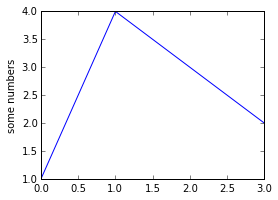

In [31]:
import matplotlib.pyplot as plt
from io import BytesIO
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch, cm
from reportlab.lib.utils import ImageReader

fig = plt.figure(figsize=(4, 3))
plt.plot([1,4,3,2])
plt.ylabel('some numbers')

imgdata = BytesIO()
fig.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data

Image = ImageReader(imgdata)

c = canvas.Canvas('test3.pdf')
c.drawImage(Image, cm, cm, inch, inch)
c.save()

!ls -l test3.pdf

## 3. Reportlab - `platypus`
Platypus is reportlab's layout engine (see the user guide from page 59). It defines the following hierarchy of templates

- **DocTemplate** - a `DocTemplate` describes the overall document

- **PageTemplate** - a `PageTemplate` describes a page in the document; usually different pages of the same document share the same template, but for example the title page might be different from the rest

- **Frame** - a `Frame` is a layout are within a page; in the most simple case there will be one frame per page, but eg for 2col layouts there will be 2 etc

- **Flowable** - a `Flowable` is something that can flow into a frame, eg text or an image

### Different page templates, different styles
The functions `myTitlePage` and `myRegularPage` define page templates. The command `styles = getSampleStyleSheet()` gets a whole list of styles that can be passed into the `Paragraph` function. 

In [32]:
def lipsum():
    return "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Aliquam ultrices ligula et libero tempus, ac pretium velit ultricies. Pellentesque sit amet vestibulum quam. Maecenas turpis ante, feugiat eu ultricies feugiat, ultricies ac elit. Praesent eleifend, nibh eu tempor consequat, nisi nunc hendrerit mi, at rhoncus massa sem quis nulla. Nunc ullamcorper mi a risus pretium, ac faucibus massa vehicula. Vestibulum venenatis aliquam felis eget hendrerit. Nulla porta massa placerat velit ultrices dictum. Curabitur mattis, lacus in convallis porta, ligula enim dignissim est, vel aliquam elit metus nec dolor. Vestibulum lacinia ac magna adipiscing iaculis. Suspendisse potenti. Nunc adipiscing magna id suscipit viverra. Sed tristique tortor ac erat mattis aliquam. Etiam nunc libero, iaculis non lectus quis, tincidunt adipiscing lacus. Aliquam in auctor dui."
#lipsum()

In [33]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch

PAGE_HEIGHT=defaultPageSize[1]; PAGE_WIDTH=defaultPageSize[0]
styles = getSampleStyleSheet()

Title = "<Document Title>"
def myTitlePage(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Bold',48)
    canvas.drawCentredString(PAGE_WIDTH/2.0, PAGE_HEIGHT-108, Title)
    canvas.restoreState()

pageinfo = " - <some document info here>"
def myRegularPage(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Roman',9)
    canvas.drawString(inch, 0.75 * inch, "page %d %s" % (doc.page, pageinfo))
    canvas.restoreState()

In [34]:
!rm test4.pdf
doc = SimpleDocTemplate("test4.pdf")
Story = [Spacer(1,2*inch)]
style = styles["Normal"]
styleH1 = styles["Heading1"]
styleH2 = styles["Heading2"]

for i in range(100): 
    if i % 10 == 0: 
        p = Paragraph("Headline 1", styleH1)
        Story.append(p)
    
    if i % 3 == 0: 
        p = Paragraph("Headline 1", styleH2)
        Story.append(p)
        
    bogustext = lipsum()
    p = Paragraph(bogustext, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))

doc.build(Story, onFirstPage=myTitlePage, onLaterPages=myRegularPage)

!ls -l test4.pdf

-rw-r--r--  1 skl  staff  29097 12 Oct 23:49 test4.pdf


### Flowables and frames

It is possible to construct a document solely based on flowables and frames

In [35]:
!rm test5.pdf

from reportlab.pdfgen.canvas import Canvas
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
from reportlab.platypus import Paragraph, Frame
styles = getSampleStyleSheet()
styleN = styles['Normal']
styleH = styles['Heading1']

story = []
story.append(Paragraph("This is a Heading",styleH))
for i in range(100):
    story.append(Paragraph(lipsum(),styleN))
    story.append(Spacer(1,0.2*inch))
c = Canvas('test5.pdf')
f = Frame(3*inch, inch, 3*inch, 9*inch, showBoundary=1)
f.addFromList(story,c)
c.save()

!ls -l test5.pdf

-rw-r--r--  1 skl  staff  2388 12 Oct 23:49 test5.pdf


### Two column layout
[source](http://stackoverflow.com/questions/13720357/reportlab-floating-text-with-two-columns)

In [36]:
from reportlab.platypus import BaseDocTemplate, Frame, Paragraph, PageBreak, PageTemplate
from reportlab.lib.styles import getSampleStyleSheet
import random

words = "lorem ipsum dolor sit amet consetetur sadipscing elitr sed diam nonumy eirmod tempor invidunt ut labore et".split()

styles=getSampleStyleSheet()
story=[]

doc = BaseDocTemplate('test6.pdf',showBoundary=1)

frame1 = Frame(doc.leftMargin, doc.bottomMargin, doc.width/2-6, doc.height, id='col1')
frame2 = Frame(doc.leftMargin+doc.width/2+6, doc.bottomMargin, doc.width/2-6, doc.height, id='col2')

story.append(Paragraph(" ".join([random.choice(words) for i in range(1000)]),styles['Normal']))
doc.addPageTemplates([PageTemplate(id='TwoCol',frames=[frame1,frame2]), ])

doc.build(story)

!ls -l test6.pdf

-rw-r--r--  1 skl  staff  4015 12 Oct 23:49 test6.pdf


### Mixed layout, one and two cols, title and back
[source](http://code.activestate.com/recipes/123612-basedoctemplate-with-2-pagetemplate/)

In [37]:
from reportlab.platypus import BaseDocTemplate, Frame, Paragraph, NextPageTemplate, PageBreak, PageTemplate, Image
from reportlab.lib.units import inch
from reportlab.lib.styles import getSampleStyleSheet

doc = BaseDocTemplate('test7.pdf',showBoundary=1)
styles=getSampleStyleSheet()
story=[]

def static_title(canvas,doc):
    canvas.saveState()
    canvas.drawImage('logo-oditorium-whitebg.jpg',doc.width-2.5*inch,doc.height, width=4*inch, preserveAspectRatio=True)
    canvas.setFont('Times-Roman',48)
    canvas.drawString(inch, doc.height - 1*inch, "TITLE")
    canvas.restoreState()
    
def static_back(canvas,doc):
    canvas.saveState()
    canvas.setFont('Times-Roman',9)
    canvas.drawString(inch, 0.75 * inch, "Back")
    canvas.restoreState()

def static_1col(canvas,doc):
    canvas.saveState()
    canvas.drawImage('logo-oditorium-whitebg.jpg',doc.width+0.5*inch,doc.height+0.5*inch, width=1*inch, preserveAspectRatio=True)
    canvas.setFont('Times-Roman',9)
    canvas.drawString(inch, 0.75 * inch, "One Col - Page %d" % doc.page)
    canvas.restoreState()

def static_2col(canvas,doc):
    canvas.saveState()
    canvas.drawImage('logo-oditorium-whitebg.jpg',doc.width+0.5*inch,doc.height+0.5*inch, width=1*inch, preserveAspectRatio=True)
    canvas.setFont('Times-Roman',9)
    canvas.drawString(inch, 0.75 * inch, "Two Col - Page %d" % doc.page)
    canvas.restoreState()

frame_title = Frame(doc.leftMargin, doc.bottomMargin, doc.width, doc.height - 5*inch, id='normal')
frame_back = Frame(doc.leftMargin, doc.bottomMargin, doc.width, doc.height - 8*inch, id='normal')

frame_1col = Frame(doc.leftMargin, doc.bottomMargin, doc.width, doc.height, id='normal')

frame1_2col = Frame(doc.leftMargin, doc.bottomMargin, doc.width/2-6, doc.height, id='col1')
frame2_2col = Frame(doc.leftMargin+doc.width/2+6, doc.bottomMargin, doc.width/2-6,
               doc.height, id='col2')

doc.addPageTemplates([
        PageTemplate(id='Title',frames=frame_title,onPage=static_title),  
        PageTemplate(id='Back',frames=frame_back,onPage=static_back),  
        PageTemplate(id='OneCol',frames=frame_1col,onPage=static_1col),  
        PageTemplate(id='TwoCol',frames=[frame1_2col,frame2_2col],onPage=static_2col),
                      ])


story.append(Paragraph("Title, "*100,styles['Normal']))
story.append(NextPageTemplate('OneCol'))
story.append(PageBreak())
for i in range(0,15): 
    story.append(Paragraph(lipsum(),styles['Normal']))
    story.append(Spacer(1,0.2*inch))
story.append(NextPageTemplate('TwoCol'))
story.append(PageBreak())
for i in range(0,15): 
    story.append(Paragraph(lipsum(),styles['Normal']))
    story.append(Spacer(1,0.2*inch))
story.append(NextPageTemplate('OneCol'))
story.append(PageBreak())
for i in range(0,5): 
    story.append(Paragraph(lipsum(),styles['Normal']))
    story.append(Spacer(1,0.2*inch))
story.append(Image('graph.png'))
for i in range(0,5): 
    story.append(Paragraph(lipsum(),styles['Normal']))
    story.append(Spacer(1,0.2*inch))
story.append(NextPageTemplate('Back'))
story.append(PageBreak())
story.append(Paragraph("Back, "*100,styles['Normal']))

doc.build(story)

!ls -l test7.pdf

-rw-r--r--  1 skl  staff  57213 12 Oct 23:49 test7.pdf


#### Landscape

In [38]:
from reportlab.platypus import BaseDocTemplate, Frame, Paragraph, NextPageTemplate, PageBreak, FrameBreak, PageTemplate, Image
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import A4, A5, landscape, portrait
from reportlab.lib.styles import getSampleStyleSheet

doc = BaseDocTemplate('test8.pdf',showBoundary=1, pagesize=landscape(A4))
styles=getSampleStyleSheet()
story=[]

def static_title(canvas,doc):
    canvas.saveState()
    canvas.setFont('Times-Roman',48)
    canvas.drawString(inch, doc.height - 1*inch, "TITLE")
    canvas.restoreState()
    
def static_page(canvas,doc):
    canvas.saveState()
    canvas.setFont('Times-Roman',9)
    canvas.drawString(inch, 0.75 * inch, "Page - Page %d" % doc.page)
    canvas.restoreState()

frame_title = Frame(doc.leftMargin, doc.bottomMargin, doc.width, doc.height - 5*inch, id='normal')

frame1_page = Frame(doc.leftMargin, doc.bottomMargin, doc.width/2-6, doc.height, id='left')
frame2_page = Frame(doc.leftMargin+doc.width/2+6, doc.bottomMargin, doc.width/2-6, doc.height, id='right')

doc.addPageTemplates([
        PageTemplate(id='Title',frames=frame_title,onPage=static_title),  
        PageTemplate(id='Page',frames=[frame1_page, frame2_page],onPage=static_page),  
                      ])


story.append(Paragraph("Title, "*100,styles['Normal']))
story.append(NextPageTemplate('Page'))
story.append(PageBreak())
story.append(Image('graph.png', width=doc.width/3))
story.append(FrameBreak())
for i in range(0,2): 
    story.append(Paragraph(lipsum(),styles['Normal']))
    story.append(Spacer(1,0.2*inch))
story.append(PageBreak())
for i in range(0,2): 
    story.append(Paragraph(lipsum(),styles['Normal']))
    story.append(Spacer(1,0.2*inch))
story.append(FrameBreak())
story.append(Image('graph.png'))

doc.build(story)

!ls -l test8.pdf

-rw-r--r--  1 skl  staff  10621 12 Oct 23:49 test8.pdf


## HTTPServer
to get access to the whole current directory, uncomment the below line and navigate the browser to this server's IP address at port `:8080` (note that this command is blocking and needs to be interrupted using the command in the Kernel menu above; this is a feature not a bug, because the server should be only run when needed)

In [39]:
#!python -m SimpleHTTPServer 8080
#!netstat -tulpn
#!kill 25239 